In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder

In [ ]:
def preprocessing_dense(train_x, train_y, test_x, test_y):
    # data Normalization
    train_x = train_x / 255.
    test_x = test_x / 255.
    
    # one hot encoding the train and test labels
    enc = OneHotEncoder(sparse=False, categories='auto')
    train_y = enc.fit_transform(train_y.reshape(len(train_y), -1))
    test_y = enc.transform(test_y.reshape(len(test_y), -1))
    
    #dividing the data into batches
    m_x,l_x = train_x.shape
    m_y,l_y = train_y.shape
    train_x = train_x.reshape(60,int(m_x/60),l_x)
    test_x = test_x.reshape(60,int(m_x/60),l_x)
    train_y = train_y.reshape(60,int(m_y/60),l_y)
    test_y = test_y.reshape(60,int(m_y/60),l_y)
 
    return train_x, train_y, test_x, test_y


In [ ]:
def sigmoid(Z): #sigmoid activation
    return 1 / (1 + np.exp(-Z))
def softmax(Z):  #softmax activation
    expZ = np.exp(Z - np.max(Z))
    return expZ / expZ.sum(axis=0, keepdims=True)
def sigmoid_derivative(Z):  #sigmoid activation derivative
    s = 1 / (1 + np.exp(-Z))
    return s * (1 - s)
def relu(Z):  #relu activation
    return np.maximum(0,Z)
def relu_derivative(Z):  #relu activation derivative
    a= relu(Z)
    a[a>0] = 1
    a[a<0] = 0
    return a


In [4]:
class Dense:
    def __init__(self, dense_architecture): # fully connected network constructor 
        self.dense_architecture = list(dense_architecture) # passing the the architecture
        self.parameters = self.init_params(self.dense_architecture) # intializing parameters according to the structure
        self.cost_hist = []
        self.acc_hist = []
 
    def init_params(self,dense_architecture):
        np.random.seed(2) # fixing seed to avoid complete randomness
        
        params = {} #dictionary for weights and biases
        
        for i, layer in enumerate(dense_architecture): #looping over architecture list to initiate parameters
            idx = i + 1  # we begin W and b from 1 because  layer0= input_layer 
            
            #picking W and b matrix dims from architecture
            layer_input_size = layer["input_dim"]
            layer_output_size = layer["output_dim"]
            
           #initiating the values of the W matrix and b with random values and normalizing them
            params['W' + str(idx)] = np.random.randn(layer_output_size, layer_input_size) * 0.01 #keeping parameters small
            params['b' + str(idx)] = np.random.randn(layer_output_size, 1) *0.01
        return params
    def forward_step(self,W,X,b,activation):
        Z = W.dot(X)+b #linear feed forward step 
        if activation == "relu":
            A = relu(Z) # applying activation
        elif activation == "sigmoid":
            A= sigmoid(Z) # applying activation
        elif activation == "softmax":
            A = softmax(Z) # applying activation
        else: 
            print("this activation is not supported")
        return A,Z
 
    def forward(self, X):
        cache = {}
 
        A = X.T
        for i,layer in enumerate(self.dense_architecture):
            W = self.parameters["W" + str(i + 1)] #fetching paramters for a specific layer from paramters dictionary 
            b = self.parameters["b" + str(i + 1)]
            activation = layer["activation"]
            A , Z = self.forward_step(W,A,b,activation) #performing the feeed forward step
            # saving results and inputs for back propagation
            cache["A" + str(i + 1)] = A
            cache["W" + str(i + 1)] = self.parameters["W" + str(i + 1)]
            cache["Z" + str(i + 1)] = Z
 
        return A, cache
 
    def log_loss(self,Y,Y_hat): # log loss cost function
        return -np.mean(Y * np.log(Y_hat.T+ 1e-8))
    def log_loss_derivative(self,Y,Y_hat,A_prev,W): # log loss cost derivative with respect to softmax
        m= Y.shape[0]
        dZ = Y_hat - Y.T
 
        dW = dZ.dot(A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = W.T.dot(dZ)
        return dA_prev,dW,db
    
    def backward(self, X, Y, cache): #backpropagation
        m = X.shape[0]
        gradients = {}
 
        cache["A0"] = X.T
 
        Y_hat = cache["A" + str(len(self.dense_architecture))]
        A_prev = cache["A" + str(len(self.dense_architecture) - 1)]
        W = cache["W" + str(len(self.dense_architecture))]
        dA_prev, dW,db = self.log_loss_derivative(Y,Y_hat,A_prev,W)
 
        gradients["dW" + str(len(self.dense_architecture))] = dW
        gradients["db" + str(len(self.dense_architecture))] = db
        archi= list(reversed(self.dense_architecture))
        archi.pop(0)
        for l,layer in enumerate(archi):
            i= len(archi)-l
            if layer["activation"] == "sigmoid":
                dZ = dA_prev * sigmoid_derivative(cache["Z" + str(i)])
            elif layer["activation"] == "relu":
                dZ = dA_prev * relu_derivative(cache["Z" + str(i)])
            else:
                print("unknown derivative")
            dW = (1/ m) * dZ.dot(cache["A" + str(i - 1)].T)
            db = (1/ m) * np.sum(dZ, axis=1, keepdims=True)
            dA_prev = cache["W" + str(i)].T.dot(dZ)
 
            gradients["dW" + str(i)] = dW
            gradients["db" + str(i)] = db
 
        return gradients,dA_prev
 
    def update(self,derivatives,lr): # updating parameteres according to learning rate and gradients
        for l in range(1, len(self.dense_architecture) + 1):
            self.parameters["W" + str(l)] = self.parameters["W" + str(l)] - lr * derivatives["dW" + str(l)]
            self.parameters["b" + str(l)] = self.parameters["b" + str(l)] - lr * derivatives["db" + str(l)]
            
    def train(self, X, Y, n_iterations=2500,lr=0.01,disp = False): #independent train function for fully connected layers
        for ep in range(n_iterations):
            m = ep%60 #selecting batch
            Y_hat, cache = self.forward(X[m]) #forward propagation
            cost = self.log_loss(Y[m],Y_hat)
            derivatives,dA_prev = self.backward(X[m], Y[m], cache) #back propagation
            self.update(derivatives,lr) #updating parameters
            acc = self.accuracy(Y[m], Y_hat) # checki accuracy by comparing Y_hat and labels 
            self.acc_hist.append(acc) # maintaining cost and accuracy history
            self.cost_hist.append(cost)
            if ep % 10 == 0 and disp == True:
                print("epoch: ",ep," Cost: ", cost, " Train Accuracy:", acc)
            
        
        return dA_prev,self.cost_hist,self.acc_hist
    def dtrain(self, X, Y,lr):# train function utility for CNN one flow through fully connected layers
        Y_hat, cache = self.forward(X)
        cost = self.log_loss(Y,Y_hat)
        derivatives,dA_prev = self.backward(X, Y, cache)
        self.update(derivatives,lr)
        acc = self.accuracy(Y, Y_hat)
        
        return dA_prev,cost,acc
    def accuracy(self,Y,Y_hat): # measures accuray by comparing y and y_hat
        y_hat = np.argmax(Y_hat, axis=0)
        Y = np.argmax(Y, axis=1)
        accuracy = (y_hat == Y).mean()
        return accuracy * 100
 
 

 


In [ ]:

def costPlot(cost_hist): #utility to plot cost
    plt.figure()
    plt.plot(np.arange(len(cost_hist)), cost_hist)
    plt.xlabel("epochs")
    plt.ylabel("cost")
    plt.show()

# Main

In [8]:
# retriving data
from mlxtend.data import loadlocal_mnist
X, y = loadlocal_mnist(
        images_path='train-images.idx3-ubyte', 
        labels_path='train-labels.idx1-ubyte')
X_test,y_test = loadlocal_mnist(
        images_path='t10k-images.idx3-ubyte', 
        labels_path='t10k-labels.idx1-ubyte')


Populating the interactive namespace from numpy and matplotlib


C:\Users\DELL\Anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


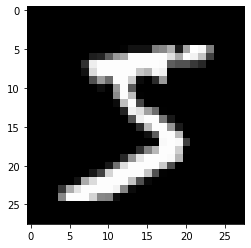

In [9]:
%pylab inline
import matplotlib.pyplot as plt
plt.imshow(X[0].reshape(28,28), cmap='gray')
plt.show()

In [10]:
print("above picture represents a: ",y[0])

above picture represents a:  5


# implementing a simple feed forward forward network on MNIST data 

In [98]:
train_x = X
train_y= y
test_x = X_test
test_y = y_test
train_x, train_y, test_x, test_y = preprocessing_dense(train_x, train_y, test_x, test_y)

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

(60000, 784) (60000, 10)
train_x's shape: (60, 1000, 784)
test_x's shape: (60, 1000, 784)


In [103]:
dense_architecture=[
    {"input_dim": 784, "output_dim": 50, "activation": "sigmoid"},
        {"input_dim": 50, "output_dim": 10, "activation": "softmax"}
    ]
ann = Dense(dense_architecture)

da_prev,cost_hist,acc_hist = ann.train(train_x, train_y, lr=0.1, n_iterations=1000)



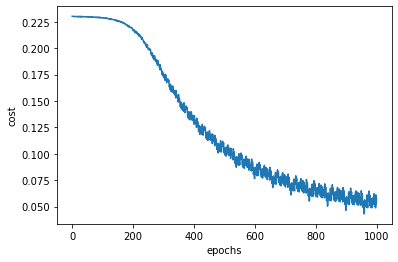

In [104]:
costPlot(cost_hist)